## Create A Network Grid from Raster Grid

This notebook takes an .asc raster file representing a DEM and extracts a channel network from the topography using the [ChannelProfiler](https://landlab.readthedocs.io/en/master/reference/components/channel_profiler.html). It then uses this extracted channel network to create a NetworkModelGrid.

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

#landlab modules
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components import DepressionFinderAndRouter

## Import a DEM
Setup this notebook to draw DEM data for the Hugo Site from the overland_flow tutorial folder.

In [2]:
tutorial_dir = os.path.dirname(os.getcwd())
raster_fn = os.path.join(tutorial_dir, 'overland_flow\\hugo_site.asc')

Import the Hugo Site as a RasterModelGrid and visualize:

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


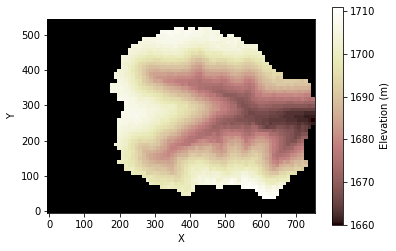

In [3]:
rmg, z = read_esri_ascii(raster_fn, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED


plt.figure()
imshow_grid_at_node(rmg, z, colorbar_label='Elevation (m)')
plt.show()

## Find flow accumulation:

Find where water will flow using the FlowAccumulator package:

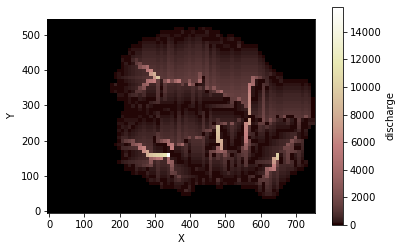

In [4]:
fa = FlowAccumulator(rmg, 
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')
fa.run_one_step()

imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

Yuck, that doesn't look like a very well defined channel network, let's fill in those depressions that are affecting the flow and then reroute it:

In [5]:
df_4 = DepressionFinderAndRouter(rmg)
df_4.map_depressions()

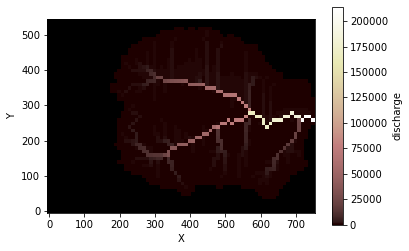

In [6]:
imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

That looks better! 

## Use the channel profiler to extract channels:
* note, toggle minimum channel threshhold to refine network!

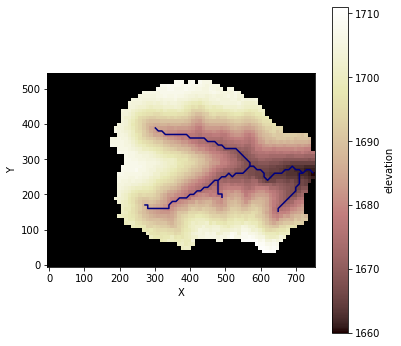

In [7]:
min_channel_thresh = 10000

profiler = ChannelProfiler(
    rmg,
    number_of_watersheds=1,
    minimum_channel_threshold=min_channel_thresh,
    main_channel_only=False,
    cmap='jet',
)
profiler.run_one_step()

plt.figure(figsize = (6,6))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')

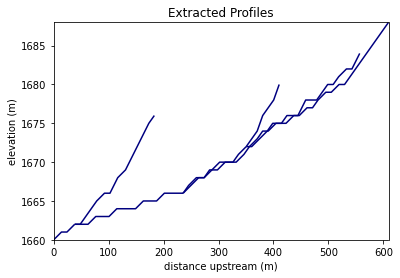

In [8]:
profiler.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)')

## Get network-grid nodes from channel.
* this is a work-in-progress...

Extract x,y network model grid (nmg) nodes from raster model grid (rmg) for each deliniated channel segment:
* note: need to remove duplicate values from channel junctures and create node_at_link list (more notes below)

In [20]:
d_node_spacing = 20 #units to space nodes, must be greater than grid resolution
x_of_nodes = np.array([]) #empty list to store x locations of network model grid nodes
y_of_nodes = np.array([]) #empty list to store y locations of network model grid nodes
rmg_nodes = np.array([]) #empty list to store raster model grid node corresponding to each network model grid node
colors_nodes = [] #empty list to store colors corresponding to each segment

#would be ideal to also create dictionary here that stores rmg cells along each link to tie rmg properties to nmg
#nmg_cells_on_link = {}

#obtain watershed key
ws_keys = [k for k in profiler.data_structure.keys()]

#sent message if there is more than 1 watershed (code is not currently set up to handle multipe watersheds)
if len(ws_keys) > 1:
    print('more than one watershed in DEM, unable to deliniate network properly')

#access number of channel segments
n_channel_segs = len(profiler.data_structure[ws_keys[0]])
#generate random colors to keep track of channel segs for plotting
colors = [list(np.random.random(3)) for i in range(n_channel_segs)] 

#loop through each segment
for i, seg_key in enumerate(profiler.data_structure[ws_keys[0]].keys()):
    
    #access individual segment
    seg_i = profiler.data_structure[2051][seg_key] 
    
    # create array of idealized node locations using previously specified distance between nodes
    node_locs = np.arange(seg_i['distances'][0], seg_i['distances'][-1], d_node_spacing)
    n_possible_nodes = len(node_locs)
    
    #Find the index of the nearest channel cells to idealized node locations:
    idx_nodes = [np.abs(seg_i['distances'] - loc).argmin() for loc in node_locs]
    
    #obtain list of raster model grid nodes corresponding to channel nodes
    rmg_nodes_i = seg_i['ids'][idx_nodes]
    rmg_nodes = np.append(rmg_nodes, rmg_nodes_i) #append to list that will connect rmg node values to nmg
    
    #append x,y values to list of network model grid nodes from raster model grid
    x_of_nodes = np.append(x_of_nodes, rmg.x_of_node[rmg_nodes_i])
    y_of_nodes = np.append(y_of_nodes, rmg.y_of_node[rmg_nodes_i])
    
    #add colors to correspond to each segment (this is just for dev plotting and can be removed later)
    for n in range(len(rmg_nodes_i)):
        colors_nodes.append(colors[i])

Plot nodes colored by segment:

Text(0.5, 1.0, 'Network Nodes colored by channel segment')

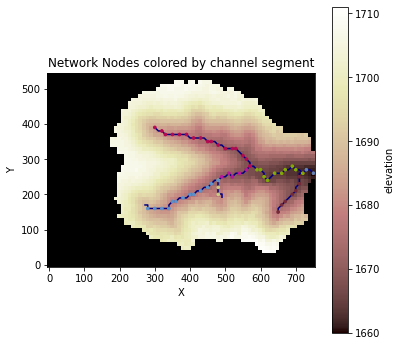

In [21]:
plt.figure(figsize = (6,6))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=7, zorder=2)
plt.title('Network Nodes colored by channel segment')

#### Figure out how to get 'node at link' value for nmg:
* this should ultimately be incorporated into above loop 

NEED TO:
* distinguish between outlet, channel head, or juncture at start and end of each segment
    * if outlet: 
        * create node at beginning
        * attach to upstream nodes
    * if juncture: 
        * create node at beginning (ONLY if a node hasn't already been created from another juncture) 
        * also tell the previous segment that it needs to be attached to this node idx (ONLY if it hasn't been attached from previous juncture)
    * if channel head: 
        * end with upstream node--don't attach to any other nodes

In [11]:
#concatenate with previous nodes here
n_existing_nodes = 0 #set to zero now since this is first segiment, should be length of some existing list of nodes later
n_new_nodes = len(x_of_nodes)
new_nodes_at_link = [(i+1, i) for i in range(n_existing_nodes, n_new_nodes+1)]
new_nodes_at_link #the final node doesn't exist yet...how to account for this in final segment (need to account for it in final segment or headwater segment)

[(1, 0),
 (2, 1),
 (3, 2),
 (4, 3),
 (5, 4),
 (6, 5),
 (7, 6),
 (8, 7),
 (9, 8),
 (10, 9),
 (11, 10),
 (12, 11),
 (13, 12),
 (14, 13),
 (15, 14),
 (16, 15),
 (17, 16),
 (18, 17),
 (19, 18),
 (20, 19),
 (21, 20),
 (22, 21),
 (23, 22),
 (24, 23),
 (25, 24),
 (26, 25),
 (27, 26),
 (28, 27),
 (29, 28),
 (30, 29),
 (31, 30),
 (32, 31),
 (33, 32),
 (34, 33),
 (35, 34),
 (36, 35),
 (37, 36),
 (38, 37),
 (39, 38),
 (40, 39),
 (41, 40),
 (42, 41),
 (43, 42),
 (44, 43),
 (45, 44),
 (46, 45),
 (47, 46),
 (48, 47),
 (49, 48),
 (50, 49),
 (51, 50),
 (52, 51),
 (53, 52),
 (54, 53),
 (55, 54),
 (56, 55),
 (57, 56),
 (58, 57),
 (59, 58),
 (60, 59)]